In [2]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def add_random_noise(x):
    x = x + np.random.normal(size=x.shape) * np.random.uniform(1, 5)
    x = x - x.min()
    x = x / x.max()
    return x * 255.0

In [4]:
TRAINING_DIR = "C:/Users/2019A00298/dataset/train-set"
VALIDATION_DIR = "C:/Users/2019A00298/dataset/test-set"
batch_size = 10

In [5]:
# Image Data Generator with Augmentation

training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.2),
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_random_noise
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [6]:
# Reading images from directory and pass them to the model

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 93 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


type of img:  <class 'numpy.ndarray'>
img.shape:  (10, 224, 224, 3)
type of label:  <class 'numpy.ndarray'>
label.shape:  (10, 3)


C:\Users\2019A00298\anaconda3\envs\capstone\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


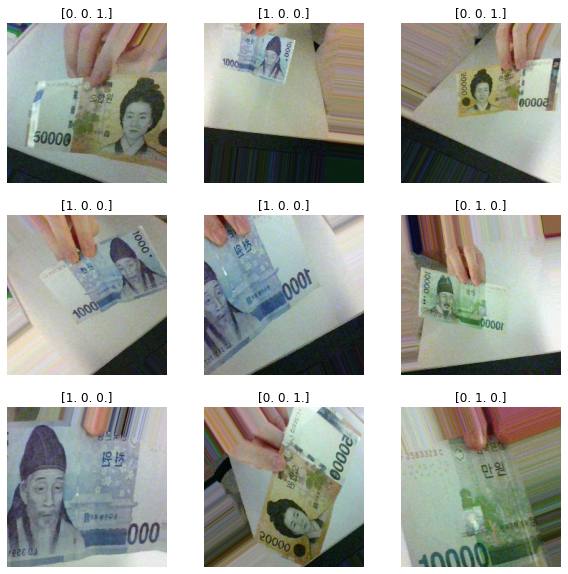

In [7]:
# Plotting the augmented imaged

img, label = next(train_generator)
print("type of img: ", type(img))
print("img.shape: ", img.shape)
print("type of label: ", type(label))
print("label.shape: ", label.shape)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i])
    plt.title(label[i])
    plt.axis('off')

plt.show()

In [8]:
# Load pre-trained base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Unfreeze the base model
base_model.trainable = True

9420800/9406464 [==============================] - 3s 0us/step


In [9]:
# Freeze the base model except the last layer of unfeeze_n_layer
unfreeze_n_layer = 10
for i in range(0, len(base_model.layers) - unfreeze_n_layer):
    base_model.layers[i].trainable = False

In [10]:
# Add custom layers
out_layer = tf.keras.layers.Conv2D(128, (1, 1), padding='SAME', activation=None)(base_model.output)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.ReLU()(out_layer)
out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.Dense(3, activation='softmax')(out_layer)

In [11]:
# Make new model
model = tf.keras.models.Model(base_model.input, out_layer)

In [12]:
# Set lower learning rate for fine tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Fine tuning
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/40
10/10 [==============================] - 6s 477ms/step - loss: 0.7160 - accuracy: 0.6989 - val_loss: 2.2215 - val_accuracy: 0.6333
Epoch 2/40
10/10 [==============================] - 4s 353ms/step - loss: 0.2656 - accuracy: 0.9140 - val_loss: 3.6384 - val_accuracy: 0.6000
Epoch 3/40
10/10 [==============================] - 4s 389ms/step - loss: 0.2189 - accuracy: 0.9140 - val_loss: 2.9744 - val_accuracy: 0.6667
Epoch 4/40
10/10 [==============================] - 4s 431ms/step - loss: 0.1277 - accuracy: 0.9785 - val_loss: 0.2126 - val_accuracy: 0.9333
Epoch 5/40
10/10 [==============================] - 4s 427ms/step - loss: 0.0972 - accuracy: 0.9785 - val_loss: 0.1566 - val_accuracy: 0.9333
Epoch 6/40
10/10 [==============================] - 4s 428ms/step - loss: 0.1038 - accuracy: 0.9677 - val_loss: 0.1235 - val_accuracy: 0.9333
Epoch 7/40
10/10 [==============================] - 4s 426ms/step - loss: 0.1298 - accuracy: 0.9570 - val_loss: 1.1275e-04 - val_accuracy: 1.0000
Ep

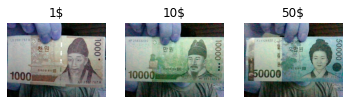

After resize and norm, imgae.shape:  (1, 224, 224, 3)


In [13]:
import glob
import cv2

INPUT_SIZE = (224, 224)
labels = np.array(['1$', '10$', '50$'])

images = [cv2.imread(file, cv2.IMREAD_COLOR) for file in glob.glob("C:/Users/2019A00298/test_img_before_make_model/*.jpg")]

plt.figure()
for i in range(len(images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.show()

for i in range(len(images)):
    images[i] = cv2.resize(images[i], dsize=INPUT_SIZE, interpolation=cv2.INTER_AREA)
    images[i] = np.expand_dims(images[i], axis=0) / 255.0

print('After resize and norm, imgae.shape: ', images[0].shape)

In [14]:
for i in range(len(images)):
    classes = model.predict(images[i])
    answer = labels[np.argmax(classes)]
    print(f'Predict image[{i}]')
    print(f'answer is: {answer}\n')


Predict image[0]
answer is: 10$

Predict image[1]
answer is: 10$

Predict image[2]
answer is: 50$



In [15]:
tf.saved_model.save(model, "C:/Users/2019A00298/new_models/money_detection/1/")

INFO:tensorflow:Assets written to: C:/Users/2019A00298/new_models/money_detection/1/assets


In [16]:
# Load saved model
loaded = tf.saved_model.load("C:/Users/2019A00298/new_models/money_detection/1/")

In [17]:
print(list(loaded.signatures.keys()))

['serving_default']


In [18]:
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)


((), {'input_1': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


In [19]:
model.output_names[0]

'dense'

In [20]:
x = images[2]
print(type(x))
print(x.shape)
print(x.dtype)
x = np.float32(x)
print(x.dtype)

<class 'numpy.ndarray'>
(1, 224, 224, 3)
float64
float32


In [22]:
labeling = infer(tf.constant(x))['dense']
predict_answer = labels[np.argsort(labeling)[0, ::-1][:1]]
print(predict_answer)

['50$']
